In [ ]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit, Filippo Quadri -*-
# -*- date : 2024-05-03 -*-
# -*- Last revision: 2024-05-21 -*-
# -*- python version : 3.9.18 -*-
# -*- Description: Notebook that summarize results-*-

In [ ]:
#Prepare Google Colab Environment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/EE-451-IAPR/project/src

# <center> EE - 451 Image Analysis and Pattern recognition </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Coin Challenge </center>
---

In [2]:
#Import libraries
import torch
import importlib
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import timm

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Import files
import constants
importlib.reload(constants)

#Classes
from data_classes.ref_data import refCoin
from data_classes.train_data import trainCoin
from data_classes.test_data import testCoin

#Functions
from visualization import *
from pickle_func import *
from pre_processing.process_func import *
from post_processing.data_augmentation import *
from post_processing.data_formating import *
from post_processing.dataloader import *
from post_processing.submission import *
from pre_processing.feature_extraction import *

#Models
from models.cnn import Basic_CNN, Advanced_CNN, CnnRadius
%load_ext autoreload
%autoreload 2


The project is structured as follow:
```
.
├── data
│   ├── ref
│   ├── results
│   ├── test
│   ├── train
│   └── train_labels.csv
├── documents
│   └── IAPR_Project_2024.pdf
├── environment.yml
├── requirements.txt
├── src
│   ├── constants.py
│   ├── data_classes
│   ├── main.ipynb
│   ├── main.py
│   ├── models
│   ├── pickle_func.py
│   ├── post_processing
│   ├── pre_processing
│   └── visualization.py
└── submissions
    └── sample_submission.csv
```

The code can be found under the src folder. Furthermore, subfolders are created to organize better the project structure. All the function responsible of the pre processing (segmentation) can be found in the dedicated folder. The same applies for the post processing, responsible for the data augmentation as well as the formating for the neural network classifier.

# 1. Load different Datasets

The first part of the process is to load the different images. Each type of data has its associated class, resp. `refCoin`, `trainCoin` and `testCoin`, in order to simplify the treatment. To save time, the attribute `save` can be set to false to avoid saving the result in the different folders.
If it is set to True, data are saved under the results folder: 
```
.
├── data
│   ├── ref
│   ├── results
│   ├── test
│   ├── train
│   └── train_labels.csv
```

Furthermore, the raw images as well as the indexes (image name) are automatically saved as pickle files to save time. These pickles are saved under `../data/{class_name}/pickle_files`. Once created these files are automatically loaded the next time the constructor is called.

In [ ]:
ref_data = refCoin(save=False)

In [4]:
train_data = trainCoin(save=False)

Loading data from pickle files


In [5]:
test_data = testCoin(save=False)

Loading data from pickle files


# 2 Data Processing

The next part of the process is to detect the coins in the different images and create single image for each coin. The class function **proceed_data** does the whole analysis. This analysis can be decomposed into several parts.

1. Finding contours:  
   The first step of the process is to find the contours. In order to effectively detect the contours, depending on the background properties, these steps are performed:
   - First of all, the image is reshaped (1/4) in order to accelerate the computation time. 1/4 was a good compromise between speed and image quality.
   - In order to distinguish the backgrounds, the standard deviation of the image is calculated. Conditions on this threshold are then set. The idea behind using the standard deviation is that the higher the standard deviation is, the more filtered the image should be. As the different backgrounds (neutral, hand, and noisy) have different structuring elements, this aims to be a good choice. To differentiate between the hand and the noisy background, the standard deviation of the contours is used: the noisy background will create a lot of small contours, while the hand will create fewer, resulting in a difference in standard deviation.
   - To find the contours itselfs, the images are then converted into grayscale. A lowpass filter (Gaussian blur) is then applied in order to reduce the noise in the image. A high pass is also created and applied to the image. The image is then thresholded on the resulting image.
   - Morphology is applied in order to clean the image and make it easier to detect the coins. First, small objects are removed and then a closing is done. 
   - The last step is to find the contours (using cv.HoughCircles). 

   This process gives very good results (1 coin is not detected in the train set(superposed coins) and two are not detected in the test set)

2. Create the masked images:
   Now that the coins are efficiently detected, a masked image is created on the original image. This is done in order to have a perfect contours on the coins. These masked images are again stored both as a dictionary (attribute of the class) and as a tuple in order to save informations about the image. These tuples have the following shape: \
   `(image_name, coin_name, contour)` \
   for instance:\
   `('L1010410', 'L1010410_0', array([812.5, 582.5,  53.6], dtype=float32))`. 
3. The last step of the process is to crop the coins. For each image, coins are detoured and return a croped image of variable shape. These croped images are stored as an array.

## 2.1 Segmentation

### 2.1.1 Performing the segmentation

In [6]:
#Process all the images :
# 1. clean the images and find the contours
# 2. create the masked images
# 3. create the coin images
# 4. if save = True, save the images and the class in a result folder
train_data.proceed_data()

Finding contours
Creating masked images
Creating coin images


In [ ]:
ref_data.proceed_data()

In [6]:
test_data.proceed_data()

Finding contours
Creating masked images
Creating coin images


## 2.1.2 Visualization

In [ ]:
contour_images = construct_contour_images(train_data.raw_data, train_data.contours)

In [ ]:
plot_side_by_side(
    original_images=train_data.raw_data,
    processed_images=contour_images,
    index=3,
    title1='Original Image',
    title2='Image with Contours'
)

In [ ]:
plot_side_by_side(
    original_images=train_data.raw_data, 
    processed_images=train_data.image_masked, 
    index=3, 
    title1='Original Image', 
    title2='Masked Image')

In [ ]:
plot_crop_coins(train_data.coins)

# 3 Classification

Now that the images have been segmented, each coin must be associated with its corresponding label. However, due to the use of Weak Supervision in the train labels (train_labels.csv), direct assignment of coins to their respective classes is not feasible.

One possible approach is manual labeling of the entire training set. Given the relatively low number of training samples (less than 400 samples), manual labeling is a viable option. Initially, this method was employed in the project to facilitate subsequent tasks such as classifier construction. However, it's important to note the inherent limitations of this technique. With a larger number of samples, the time and effort required for manual labeling would become prohibitively high, rendering it impractical. Consequently, alternative strategies need to be explored.

## 3.1 Automatic labelisation

An attempt was made to automate the labeling process. This involved several key steps:

1. Feature Selection:
    Identifying effective features is crucial for optimal class separation. In this context, multiple features were utilized:
    - LBP features (Local Binary Pattern)
    - Average color of the image
    - Image size

2. Application of Unsupervised Learning:
    Following feature extraction, the data was partitioned into the requisite number of classes (16 in this instance). To achieve this, a Gaussian Mixture Model was employed. Additionally, to mitigate the curse of dimensionality, Principal Component Analysis (PCA) was conducted to reduce the input dimensionality.

3. Mapping Labels to Ground Truth:
    The final step involved associating the identified labels with the actual labels provided by the *train_label.csv* file. To accomplish this task, the Hungarian Algorithm was utilized. This algorithm is a combinatorial optimization technique that establishes relationships between the number of samples found in each cluster and the actual count of elements per category.

Despite these efforts, the accuracy of this approach was unsatisfactory, precluding its continuation for subsequent stages of the project.


In [54]:
coin_images = [coin for _,_,coin in train_data.coins]

In [65]:
coin_labels_auto = associate_labels(coin_images)

Silhouette Score: 0.23338638292939937
Cluster 0 is mapped to coin type 13, which is a 0.05EUR 
Cluster 1 is mapped to coin type 10, which is a 0.5EUR 
Cluster 2 is mapped to coin type 16, which is a OOD
Cluster 3 is mapped to coin type 6, which is a 0.1CHF 
Cluster 4 is mapped to coin type 2, which is a 2CHF 
Cluster 5 is mapped to coin type 7, which is a 0.05CHF 
Cluster 6 is mapped to coin type 14, which is a 0.02EUR 
Cluster 7 is mapped to coin type 8, which is a 2EUR 
Cluster 8 is mapped to coin type 11, which is a 0.2EUR 
Cluster 9 is mapped to coin type 12, which is a 0.1EUR 
Cluster 10 is mapped to coin type 9, which is a 1EUR 
Cluster 11 is mapped to coin type 15, which is a 0.01EUR 
Cluster 12 is mapped to coin type 1, which is a 5CHF 
Cluster 13 is mapped to coin type 3, which is a 1CHF 
Cluster 14 is mapped to coin type 5, which is a 0.2CHF 
Cluster 15 is mapped to coin type 4, which is a 0.5CHF 


## 3.2 Fetch the labels (hand)

This second method uses the labels done by hand. It ensures to have 100% accuracy for the rest of the process.
First, a conversion table is builded to match the text label (e.g. 5CHF) to an int representation. A DataFrame, coin_labels summarizes all the informations about the coins labels and the coin image name.

A next step will be to regroup all the informations (image name, coin name, the coin image, the label, the radius) in a single place to proceed to the classification. This is done by the functions `create_train_data_structure` and `create_test_data_structure`

In [7]:
conversion_table = get_classes_conv_table()

In [8]:
# Associate the labels to the coins
coin_labels = get_coin_labels()

In [95]:
display(coin_labels.head(5))

,image_name,Label
0,L1010277_0,5CHF
1,L1010277_1,0.5EUR
2,L1010277_2,0.2EUR
3,L1010277_3,2EUR
4,L1010277_4,0.2EUR


Test the similarity between the two methods

In [93]:
coin_labels_values = np.array([conversion_table[label] for label in coin_labels['Label']])
accuracy = np.sum(np.array(coin_labels_auto) == coin_labels_values) / len(coin_labels_values)
print(f'The accuracy of the automatic labeling is {accuracy}')

The accuracy of the automatic labeling is 0.05235602094240838


In [9]:
# Extract the images and the labels + create a dataframe that summarize the data
train_images_raw, train_radius_infos, labels, df_train_images_labels = create_train_data_structure(train_data.coins, train_data.contours_tuple, coin_labels,conversion_table)

In [98]:
display(df_train_images_labels.head(3))

,image_name,coin_name,label,label_int,contour,radius
0,L1010410,L1010410_0,0.5CHF,3,"[812.5, 582.5, 53.6]",53.599998
1,L1010410,L1010410_1,OOD,15,"[876.5, 427.5, 76.4]",76.400002
2,L1010410,L1010410_2,0.1EUR,11,"[703.5, 434.5, 58.0]",58.000000


In [10]:
test_imgs, test_radius_infos, df_test_images = create_test_data_structure(test_data.coins, test_data.contours_tuple)

AttributeError: 'testCoin' object has no attribute 'coins'

In [102]:
display(df_test_images.head(3))

,image_name,coin_name,contour,radius
0,L0000106,L0000106_0,"[566.5, 215.5, 69.8]",69.800003
1,L0000106,L0000106_1,"[319.5, 431.5, 64.6]",64.599998
2,L0000106,L0000106_2,"[436.5, 327.5, 62.8]",62.799999


In [11]:
# Optional: Save the data in pickle files to avoid reprocessing the data
#           The data can be loaded using the load_pickle function
#           The data is saved in the folder ../data/results/pickle_files   
save_pickle(test_imgs, 'test_imgs.pkl')
save_pickle(test_radius_infos, 'test_radius_infos.pkl')
save_pickle(df_test_images, 'df_test_images.pkl')

In [ ]:
# Optional : save the coins in ../data/results/coins_classified
#           the coins are separated in folders according to their class
save_coins_classified(df_train_images_labels, train_images_raw)

The label of the coin is 0, which corresponds to a 5CHF


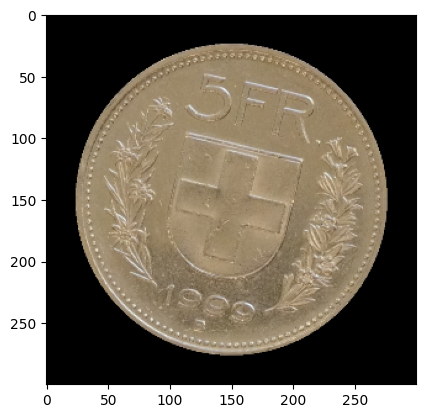

In [19]:
index = 56
label_name = list(conversion_table.keys())[list(conversion_table.values()).index(labels[index])]
plt.imshow(train_images_raw[index], cmap='gray')
print(f'The label of the coin is {labels[index]}, which corresponds to a {label_name}')

## 3.3 Data augmentation and train/validation split

The next step before classification is to separate the training values into training and validation sets. The ratio is set in the **constants.py** file.

Data augmentation is also performed to improve the results and expand the training set. Several methods have been used:
- **Rotations**: Rotations are applied to ensure the model can recognize coins from every direction.
- **Gaussian Blur**: With a certain probability, Gaussian blur is applied to images to enhance the model's robustness.
- **Gamma Correction**: This augmentation is used to correct the difference in luminescence in the image. 
    - Gamma > 1: Darkens the image.
    - Gamma < 1: Brightens the image.


In [11]:
# Create the splits (train and validation)
train_images, train_radius, train_labels, val_images, val_radius, val_labels = create_splits(
    train_images_raw, 
    train_radius_infos, 
    labels,
    ratio=constants.RATIO)

In [12]:
# Augment the training set with rotations
train_images_aug, train_radius_aug, train_labels_aug = augment_set_rotations(train_images, train_radius, train_labels)

# Augment the training set with Gaussian blur
train_images_aug, train_radius_aug, train_labels_aug = augment_blur(train_images_aug,train_radius_aug, train_labels_aug)

# Augment the training set with histogram equalization
train_images_aug, train_radius_aug, train_labels_aug = augment_histogram_equalization(train_images_aug, train_radius_aug, train_labels_aug)

# Augment the training set with gamma correction
train_images_aug, train_radius_aug, train_labels_aug = augment_gamma_correction(train_images_aug, train_radius_aug, train_labels_aug)

# transform the images to np.array
# train_images_aug = np.array(train_images_aug)
# train_radius_aug = np.array(train_radius_aug)
# train_labels_aug = np.array(train_labels_aug)
# val_images = np.array(val_images)
# val_radius = np.array(val_radius)
# val_labels = np.array(val_labels)


In [18]:
len(train_images_aug)

14261

Save the resultings arrays in pickle format in order to save time. These array can be directly loaded when needed

In [39]:
#Optional : save the datasets in ../data/results/pickle_files
save_pickle(result=train_images_aug, file_name='train_images_aug_resized.pkl')
save_pickle(result=train_radius_aug, file_name='train_radius_aug.pkl')
save_pickle(result=train_labels_aug, file_name='train_labels_aug.pkl')

save_pickle(result=val_images, file_name='val_images_resized.pkl')
save_pickle(result=val_radius, file_name='val_radius.pkl')
save_pickle(result=val_labels, file_name='val_labels.pkl')

In [ ]:
# Optional : Load precomputed data
train_images_aug = load_pickle('train_images_aug_resized.pkl')
train_images_labels= load_pickle('train_labels_aug.pkl')
train_radius = load_pickle('train_radius_aug.pkl')

val_images = load_pickle('val_images_resized.pkl')
val_radius = load_pickle('val_radius.pkl')
val_images_labels = load_pickle('val_labels.pkl')

test_imgs = load_pickle('test_imgs.pkl')
test_radius_infos = load_pickle('test_radius_infos.pkl')
df_test_images = load_pickle('df_test_images.pkl')

# 4 Train Neural Network


To perform the classification, a neural network has been chosen. More precisely a Convolutional Neural Network has been chosen. This kind of neural network has shown very high performance for computer vision tasks. For this projects, several models are proposed.
1. **Basic CNN**: This first approach consists of a basic CNN wiht only few layers (details can be found under ./models/cnn.yp). 
2. **Advanced CNN**: The second model is a more elaborated CNN model, with multiple layers. 
3. **Advanced CNN with Radius Informations**: In this approach, the same CNN as in point 2 has been used, but before the fully connected layer, the information of the radius has been inserted. 
4. **Efficient-net**: A last approach is to use a pre-trained model. This model has been trained on ImageNet 1k.

All the results can be found in the README.md file.

## 4.1 Create Dataloader

In [ ]:
train_dataloader, val_dataloader = create_dataloader(
    train_images=train_images_aug,
    train_labels=train_images_labels,
    train_radius=None,#train_radius_aug, #Set to None if not needed
    val_images=val_images, #Set to None if not needed
    val_labels=val_images_labels,
    val_radius=None)#val_radius)

In [ ]:
test_dataloader = create_test_dataloader(test_imgs, None)#test_radius_infos)

## 4.2 Custom Basic CNN

In [15]:
image_dim = np.array(train_images_aug[0]).shape[0]
num_classes = len(conversion_table)

In [ ]:
# Define the model
cnn = Basic_CNN(img_size=image_dim, num_classes=num_classes)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    train_dataloader,
    val_dataloader,
)

torch_file_name = f"Basic_CNN_{image_dim}"
# Save the model
torch.save(cnn, os.path.join(constants.MODEL_PATH, torch_file_name))

In [ ]:
predictions = cnn.predict(test_dataloader)

In [ ]:
df_submission = create_submission_file(predictions, df_test_images, conversion_table)

## 4.3 Custom Advanced CNN

In [ ]:
# Define the model
cnn = Advanced_CNN(img_size=image_dim, num_classes=num_classes)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    train_dataloader,
    val_dataloader,
)
torch_file_name = f"Advanced_CNN_{image_dim}"
# Save the model
torch.save(cnn, os.path.join(constants.MODEL_PATH, torch_file_name))

In [ ]:
predictions = cnn.predict(test_dataloader)

In [ ]:
df_submission_advanced = create_submission_file(predictions, df_test_images, conversion_table, name='submission_advanced.csv')

## 4.3 Custom CNN with Radius Informations

In [ ]:
# Define the model
cnn = CnnRadius(img_size=image_dim, num_classes=num_classes)

# Define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# Define the scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    train_dataloader,
    val_dataloader,
)
torch_file_name = f"Advanced_CNN_Radius{image_dim}"
# Save the model
torch.save(cnn, os.path.join(constants.MODEL_PATH, torch_file_name))

In [ ]:
predictions = cnn.predict(test_dataloader)

In [ ]:
df_submission_radius = create_submission_file(predictions, df_test_images, conversion_table)

## 4.4 EFFICIENT-NET

In [ ]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader}
dataset_sizes = {x: len(dataloaders[x]) * constants.BATCH_SIZE for x in ['train', 'val']}

In [ ]:
# 3. Load a pre-trained model and modify the final layer
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)

# 4. Define criterion, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 5. Training loop
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10)

def predict(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    predictions = []

    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

    return predictions

In [ ]:
    def train_model(
        self, optimizer, scheduler, train_loader, val_loader, num_epochs=10
    ):
        """
        Train the model.

        Args:
            optimizer (torch.optim): Optimizer used for training.
            scheduler (torch.optim.lr_scheduler): Scheduler used for training.
            train_loader (torch.utils.data.DataLoader): Training data loader.
            val_loader (torch.utils.data.DataLoader): Validation data loader.
            num_epochs (int): Number of epochs.
        """
        self.to(self.device)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(num_epochs):
            self.train()
            for input, target in train_loader:
                input, target = input.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            # Validation loop
            self.eval()
            with torch.no_grad():
                total_correct = 0
                test_loss = 0
                for input, target in val_loader:
                    input, target = input.to(self.device), target.to(self.device)
                    output = self(input)
                    predictions = output.argmax(dim=1)
                    total_correct += (predictions == target).sum().item()
                    test_loss += criterion(output, target).item() * len(input)

                test_loss /= len(val_loader.dataset)
                accuracy = total_correct / len(val_loader.dataset)
                print(
                    f"Epoch {epoch+1}/{num_epochs}, Loss: {test_loss}, Validation Accuracy: {accuracy:.4f}"
                )

            scheduler.step(test_loss)

    def predict(self, test_loader):
        """
        Compute predictions on the test set.

        Args:
            test_loader (torch.utils.data.DataLoader): Test data loader.

        Returns:
            predictions (np.ndarray): Predictions on the test set.
        """
        self.eval()
        predictions = []
        device = next(self.parameters()).device

        with torch.no_grad():
            for input in test_loader:
                input = input.to(self.device)
                output = self(input)
                output = output.argmax(dim=1)
                predictions.append(output.cpu())

        return torch.cat(predictions).numpy().ravel()